In [1]:
import os
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('../..')

In [3]:
from src.models.kmeans import load_per_example_metrics_df
from src.models.kmeans_delta import compute_f1_deltas

/home/sgeorge/.conda/envs/rclearn/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
BATCH_SIZE = 32

In [5]:
per_example_metrics_df = load_per_example_metrics_df(seed=29)

compute_f1_deltas(per_example_metrics_df)

2021-09-08 23:16:41,356 - Loading per example metrics
2021-09-08 23:16:46,869 - (1628400, 6)


In [6]:
per_example_metrics_df.head()

,id,checkpoint,seed,exact_match,f1,dataset,f1_delta
20585,000bcf40cda48527886c945b612c0c54ed46dff8,2,29,0.0,12.5,dbidaf,0.0
20590,000bcf40cda48527886c945b612c0c54ed46dff8,3,29,0.0,12.5,dbidaf,0.0
20592,000bcf40cda48527886c945b612c0c54ed46dff8,4,29,0.0,12.5,dbidaf,0.0
20583,000bcf40cda48527886c945b612c0c54ed46dff8,5,29,0.0,12.5,dbidaf,0.0
20529,000bcf40cda48527886c945b612c0c54ed46dff8,6,29,0.0,12.5,dbidaf,0.0


### 7 clusters

In [7]:
clusters_df = pd.read_csv('data/processed/squadv1-adversarialall-delta-clusters-seed=29-km_seed=27-n_clusters=7.csv')
print(clusters_df.shape)
clusters_df.head()

(13570, 4)


,id,KM_label,km_seed,model_seed
0,000bcf40cda48527886c945b612c0c54ed46dff8,4,27,29
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,1,27,29
2,00245d3e103a58ff1e76c4996721a03a70412422,5,27,29
3,004241bb0375392cd909e85aeedbdf9b2f899def,6,27,29
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,4,27,29


In [8]:
clusters_df['KM_label'].nunique()

7

In [9]:
per_example_metrics_df = per_example_metrics_df.merge(clusters_df, left_on=['id', 'seed'], right_on=['id', 'model_seed'])
print(per_example_metrics_df.shape)
per_example_metrics_df.head()

(1614830, 10)


,id,checkpoint,seed,exact_match,f1,dataset,f1_delta,KM_label,km_seed,model_seed
0,000bcf40cda48527886c945b612c0c54ed46dff8,2,29,0.0,12.5,dbidaf,0.0,4,27,29
1,000bcf40cda48527886c945b612c0c54ed46dff8,3,29,0.0,12.5,dbidaf,0.0,4,27,29
2,000bcf40cda48527886c945b612c0c54ed46dff8,4,29,0.0,12.5,dbidaf,0.0,4,27,29
3,000bcf40cda48527886c945b612c0c54ed46dff8,5,29,0.0,12.5,dbidaf,0.0,4,27,29
4,000bcf40cda48527886c945b612c0c54ed46dff8,6,29,0.0,12.5,dbidaf,0.0,4,27,29


In [10]:
per_example_metrics_df['num_examples'] = per_example_metrics_df['checkpoint'] * BATCH_SIZE

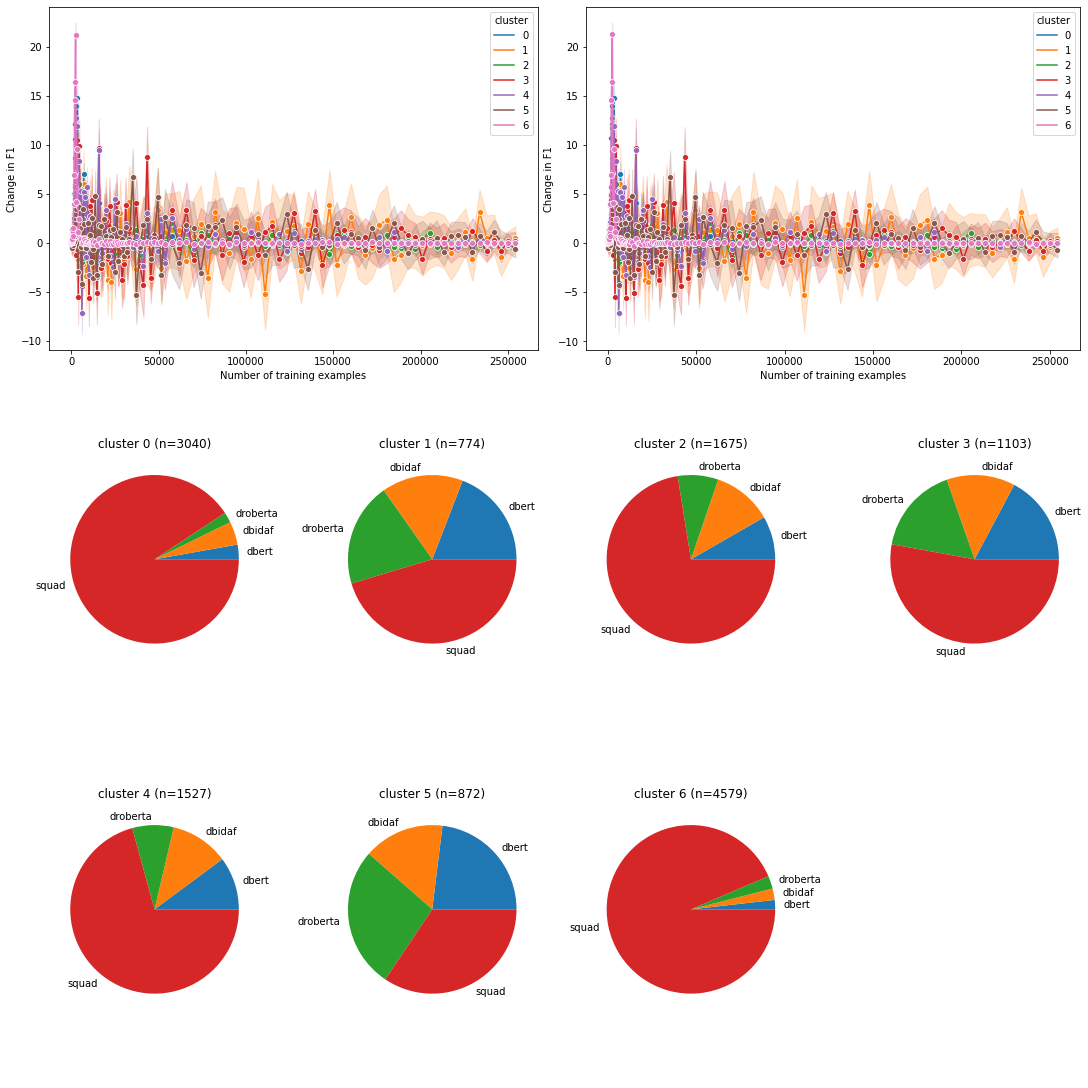

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(15, 15))
gs = fig.add_gridspec(3, 4)
f_ax1 = fig.add_subplot(gs[0, :2])  # Full trajectory
f_ax2 = fig.add_subplot(gs[0, 2:])  # <2.5k
f_ax3 = fig.add_subplot(gs[1, 0])  # Pie chart 1
f_ax4 = fig.add_subplot(gs[1, 1])  # Pie chart 2
f_ax5 = fig.add_subplot(gs[1, 2])  # Pie chart 3
f_ax6 = fig.add_subplot(gs[1, 3])  # Pie chart 4
f_ax7 = fig.add_subplot(gs[2, 0])  # Pie chart 5
f_ax8 = fig.add_subplot(gs[2, 1])  # Pie chart 6
f_ax9 = fig.add_subplot(gs[2, 2])  # Pie chart 7
f_ax10 = fig.add_subplot(gs[2, 3])  # Pie chart 8 (Blank)

plot_df = per_example_metrics_df.copy()

# Full trajectory
sns.lineplot(
    data=plot_df, 
    x='num_examples', 
    y='f1_delta', 
    hue='KM_label',
    palette='tab10',
    marker='o',
    ax=f_ax1
)
f_ax1.set_ylabel('Change in F1')
f_ax1.set_xlabel('Number of training examples')
f_ax1.legend(title='cluster')

# <5k
sns.lineplot(
    data=plot_df,  #[plot_df['num_examples']< 5000], 
    x='num_examples', 
    y='f1_delta', 
    hue='KM_label',
    palette='tab10',
    marker='o',
    ax=f_ax2
)
f_ax2.set_ylabel('Change in F1')
f_ax2.set_xlabel('Number of training examples')
f_ax2.legend(title='cluster')

# Pie charts

subset = plot_df.copy()[['id', 'dataset', 'KM_label']].drop_duplicates()  # Duplicated due to multiple checkpoints

f_ax3.pie(
    x=subset[subset['KM_label'] == 0].groupby('dataset')['id'].count().reset_index()['id'],
    labels=subset[subset['KM_label'] == 0].groupby('dataset')['id'].count().reset_index()['dataset']
)
n = subset[subset['KM_label'] == 0].shape[0]
f_ax3.set_title(f'cluster 0 (n={n})')

f_ax4.pie(
    x=subset[subset['KM_label'] == 1].groupby('dataset')['id'].count().reset_index()['id'],
    labels=subset[subset['KM_label'] == 1].groupby('dataset')['id'].count().reset_index()['dataset']
)
n = subset[subset['KM_label'] == 1].shape[0]
f_ax4.set_title(f'cluster 1 (n={n})')

f_ax5.pie(
    x=subset[subset['KM_label'] == 2].groupby('dataset')['id'].count().reset_index()['id'],
    labels=subset[subset['KM_label'] == 2].groupby('dataset')['id'].count().reset_index()['dataset']
)
n = subset[subset['KM_label'] == 2].shape[0]
f_ax5.set_title(f'cluster 2 (n={n})')

f_ax6.pie(
    x=subset[subset['KM_label'] == 3].groupby('dataset')['id'].count().reset_index()['id'],
    labels=subset[subset['KM_label'] == 3].groupby('dataset')['id'].count().reset_index()['dataset']
)
n = subset[subset['KM_label'] == 3].shape[0]
f_ax6.set_title(f'cluster 3 (n={n})')

f_ax7.pie(
    x=subset[subset['KM_label'] == 4].groupby('dataset')['id'].count().reset_index()['id'],
    labels=subset[subset['KM_label'] == 4].groupby('dataset')['id'].count().reset_index()['dataset']
)
n = subset[subset['KM_label'] == 4].shape[0]
f_ax7.set_title(f'cluster 4 (n={n})')

f_ax8.pie(
    x=subset[subset['KM_label'] == 5].groupby('dataset')['id'].count().reset_index()['id'],
    labels=subset[subset['KM_label'] == 5].groupby('dataset')['id'].count().reset_index()['dataset']
)
n = subset[subset['KM_label'] == 5].shape[0]
f_ax8.set_title(f'cluster 5 (n={n})')

f_ax9.pie(
    x=subset[subset['KM_label'] == 6].groupby('dataset')['id'].count().reset_index()['id'],
    labels=subset[subset['KM_label'] == 6].groupby('dataset')['id'].count().reset_index()['dataset']
)
n = subset[subset['KM_label'] == 6].shape[0]
f_ax9.set_title(f'cluster 6 (n={n})')

# blank
f_ax10.axis('off')

# plt.savefig(f'reports/figures/confidence-clusters-with-f1.pdf')
plt.show()

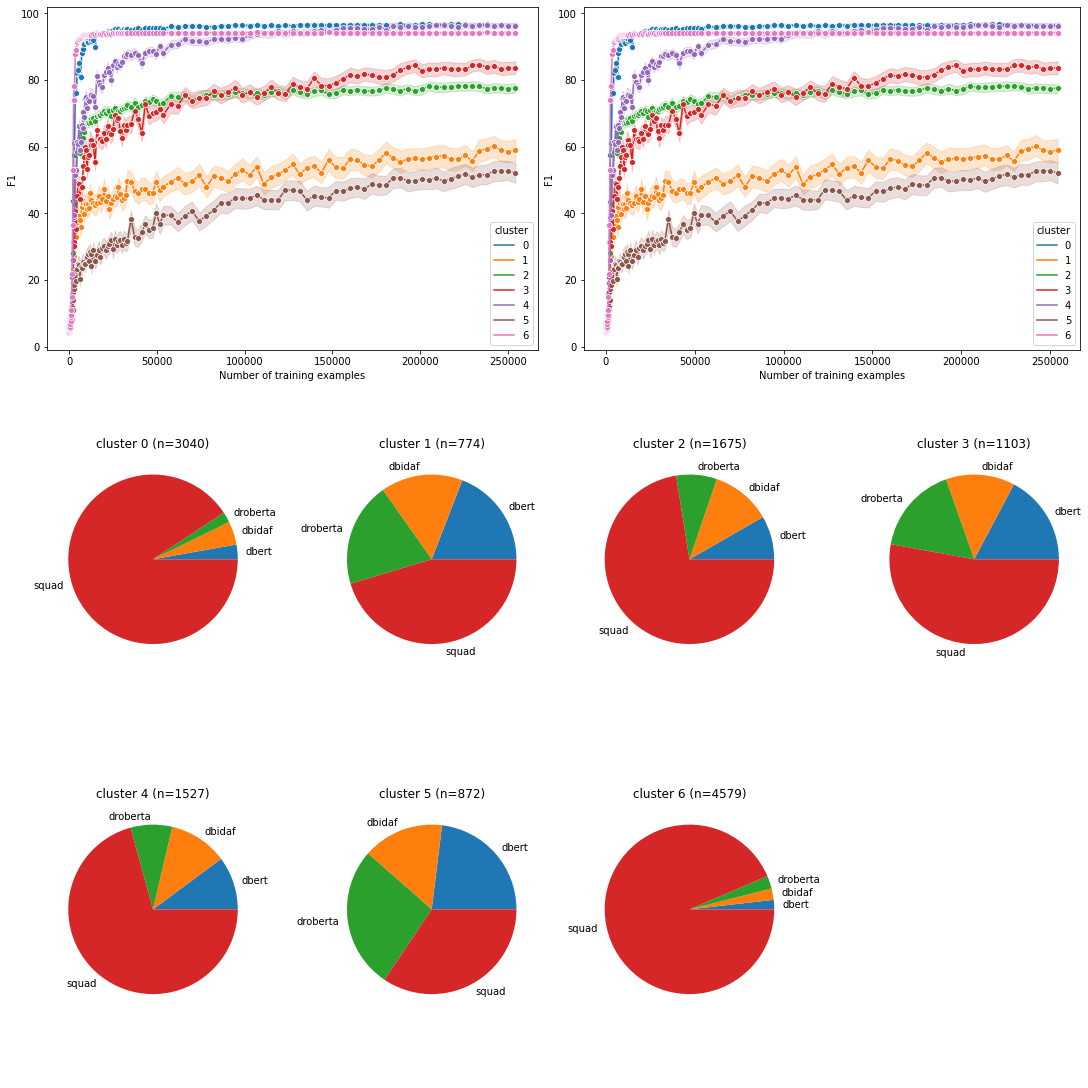

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(15, 15))
gs = fig.add_gridspec(3, 4)
f_ax1 = fig.add_subplot(gs[0, :2])  # Full trajectory
f_ax2 = fig.add_subplot(gs[0, 2:])  # <2.5k
f_ax3 = fig.add_subplot(gs[1, 0])  # Pie chart 1
f_ax4 = fig.add_subplot(gs[1, 1])  # Pie chart 2
f_ax5 = fig.add_subplot(gs[1, 2])  # Pie chart 3
f_ax6 = fig.add_subplot(gs[1, 3])  # Pie chart 4
f_ax7 = fig.add_subplot(gs[2, 0])  # Pie chart 5
f_ax8 = fig.add_subplot(gs[2, 1])  # Pie chart 6
f_ax9 = fig.add_subplot(gs[2, 2])  # Pie chart 7
f_ax10 = fig.add_subplot(gs[2, 3])  # Pie chart 8 (Blank)

plot_df = per_example_metrics_df.copy()

# Full trajectory
sns.lineplot(
    data=plot_df, 
    x='num_examples', 
    y='f1', 
    hue='KM_label',
    palette='tab10',
    marker='o',
    ax=f_ax1
)
f_ax1.set_ylabel('F1')
f_ax1.set_xlabel('Number of training examples')
f_ax1.legend(title='cluster')

# <5k
sns.lineplot(
    data=plot_df,  #[plot_df['num_examples']< 5000], 
    x='num_examples', 
    y='f1', 
    hue='KM_label',
    palette='tab10',
    marker='o',
    ax=f_ax2
)
f_ax2.set_ylabel('F1')
f_ax2.set_xlabel('Number of training examples')
f_ax2.legend(title='cluster')

# Pie charts

subset = plot_df.copy()[['id', 'dataset', 'KM_label']].drop_duplicates()  # Duplicated due to multiple checkpoints

f_ax3.pie(
    x=subset[subset['KM_label'] == 0].groupby('dataset')['id'].count().reset_index()['id'],
    labels=subset[subset['KM_label'] == 0].groupby('dataset')['id'].count().reset_index()['dataset']
)
n = subset[subset['KM_label'] == 0].shape[0]
f_ax3.set_title(f'cluster 0 (n={n})')

f_ax4.pie(
    x=subset[subset['KM_label'] == 1].groupby('dataset')['id'].count().reset_index()['id'],
    labels=subset[subset['KM_label'] == 1].groupby('dataset')['id'].count().reset_index()['dataset']
)
n = subset[subset['KM_label'] == 1].shape[0]
f_ax4.set_title(f'cluster 1 (n={n})')

f_ax5.pie(
    x=subset[subset['KM_label'] == 2].groupby('dataset')['id'].count().reset_index()['id'],
    labels=subset[subset['KM_label'] == 2].groupby('dataset')['id'].count().reset_index()['dataset']
)
n = subset[subset['KM_label'] == 2].shape[0]
f_ax5.set_title(f'cluster 2 (n={n})')

f_ax6.pie(
    x=subset[subset['KM_label'] == 3].groupby('dataset')['id'].count().reset_index()['id'],
    labels=subset[subset['KM_label'] == 3].groupby('dataset')['id'].count().reset_index()['dataset']
)
n = subset[subset['KM_label'] == 3].shape[0]
f_ax6.set_title(f'cluster 3 (n={n})')

f_ax7.pie(
    x=subset[subset['KM_label'] == 4].groupby('dataset')['id'].count().reset_index()['id'],
    labels=subset[subset['KM_label'] == 4].groupby('dataset')['id'].count().reset_index()['dataset']
)
n = subset[subset['KM_label'] == 4].shape[0]
f_ax7.set_title(f'cluster 4 (n={n})')

f_ax8.pie(
    x=subset[subset['KM_label'] == 5].groupby('dataset')['id'].count().reset_index()['id'],
    labels=subset[subset['KM_label'] == 5].groupby('dataset')['id'].count().reset_index()['dataset']
)
n = subset[subset['KM_label'] == 5].shape[0]
f_ax8.set_title(f'cluster 5 (n={n})')

f_ax9.pie(
    x=subset[subset['KM_label'] == 6].groupby('dataset')['id'].count().reset_index()['id'],
    labels=subset[subset['KM_label'] == 6].groupby('dataset')['id'].count().reset_index()['dataset']
)
n = subset[subset['KM_label'] == 6].shape[0]
f_ax9.set_title(f'cluster 6 (n={n})')

# blank
f_ax10.axis('off')

# plt.savefig(f'reports/figures/confidence-clusters-with-f1.pdf')
plt.show()

### 10 clusters

In [13]:
per_example_metrics_df = load_per_example_metrics_df(seed=29)

compute_f1_deltas(per_example_metrics_df)

2021-09-08 23:19:44,853 - Loading per example metrics
2021-09-08 23:19:45,968 - (1628400, 6)


In [14]:
per_example_metrics_df.head()

,id,checkpoint,seed,exact_match,f1,dataset,f1_delta
20585,000bcf40cda48527886c945b612c0c54ed46dff8,2,29,0.0,12.5,dbidaf,0.0
20590,000bcf40cda48527886c945b612c0c54ed46dff8,3,29,0.0,12.5,dbidaf,0.0
20592,000bcf40cda48527886c945b612c0c54ed46dff8,4,29,0.0,12.5,dbidaf,0.0
20583,000bcf40cda48527886c945b612c0c54ed46dff8,5,29,0.0,12.5,dbidaf,0.0
20529,000bcf40cda48527886c945b612c0c54ed46dff8,6,29,0.0,12.5,dbidaf,0.0


In [15]:
clusters_df = pd.read_csv('data/processed/squadv1-adversarialall-delta-clusters-seed=29-km_seed=27-n_clusters=10.csv')
print(clusters_df.shape)
clusters_df.head()

(13570, 4)


,id,KM_label,km_seed,model_seed
0,000bcf40cda48527886c945b612c0c54ed46dff8,8,27,29
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,4,27,29
2,00245d3e103a58ff1e76c4996721a03a70412422,5,27,29
3,004241bb0375392cd909e85aeedbdf9b2f899def,7,27,29
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,8,27,29


In [16]:
clusters_df['KM_label'].nunique()

10

In [17]:
per_example_metrics_df = per_example_metrics_df.merge(clusters_df, left_on=['id', 'seed'], right_on=['id', 'model_seed'])
print(per_example_metrics_df.shape)
per_example_metrics_df.head()

(1614830, 10)


,id,checkpoint,seed,exact_match,f1,dataset,f1_delta,KM_label,km_seed,model_seed
0,000bcf40cda48527886c945b612c0c54ed46dff8,2,29,0.0,12.5,dbidaf,0.0,8,27,29
1,000bcf40cda48527886c945b612c0c54ed46dff8,3,29,0.0,12.5,dbidaf,0.0,8,27,29
2,000bcf40cda48527886c945b612c0c54ed46dff8,4,29,0.0,12.5,dbidaf,0.0,8,27,29
3,000bcf40cda48527886c945b612c0c54ed46dff8,5,29,0.0,12.5,dbidaf,0.0,8,27,29
4,000bcf40cda48527886c945b612c0c54ed46dff8,6,29,0.0,12.5,dbidaf,0.0,8,27,29


In [18]:
per_example_metrics_df['num_examples'] = per_example_metrics_df['checkpoint'] * BATCH_SIZE

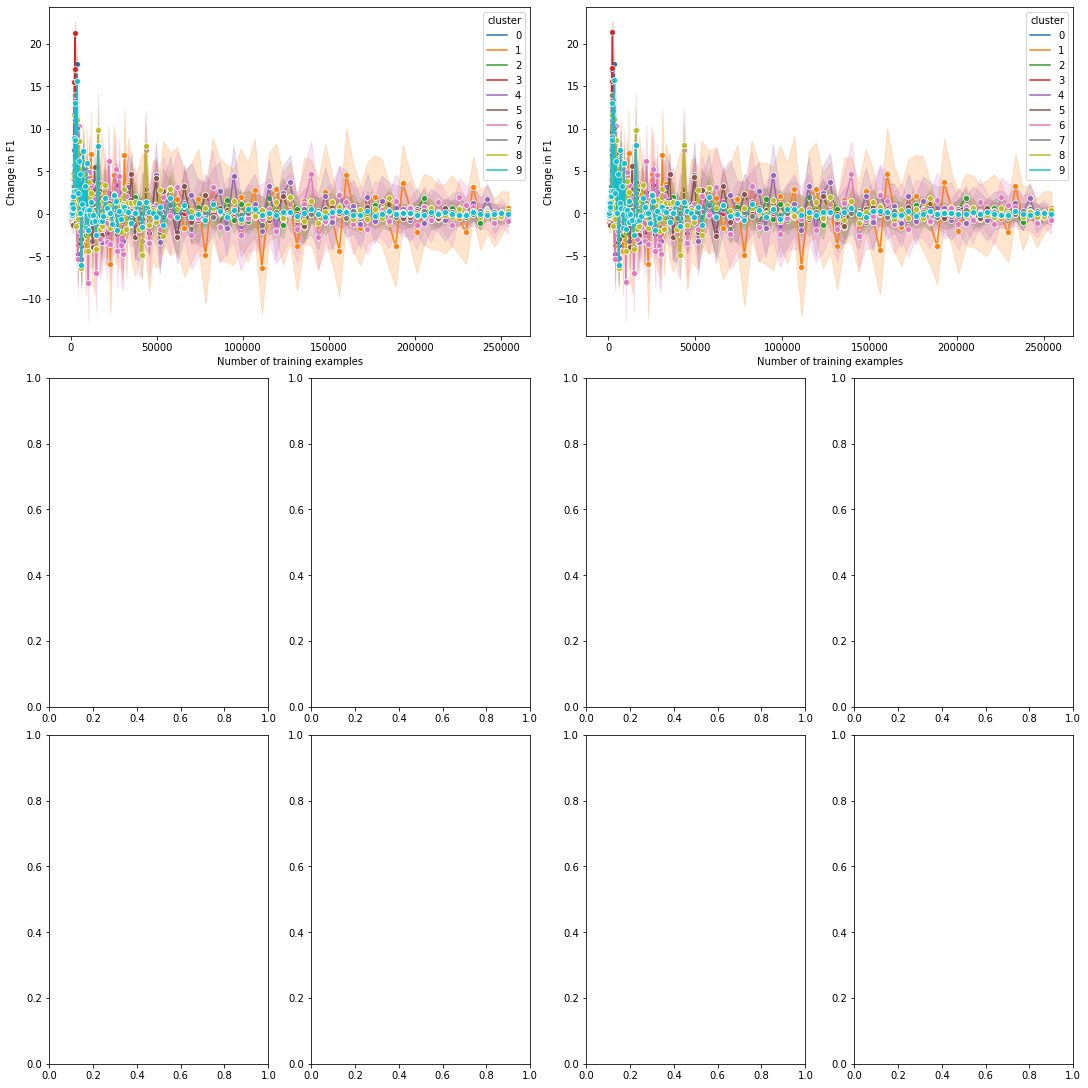

In [19]:
fig = plt.figure(constrained_layout=True, figsize=(15, 15))
gs = fig.add_gridspec(3, 4)
f_ax1 = fig.add_subplot(gs[0, :2])  # Full trajectory
f_ax2 = fig.add_subplot(gs[0, 2:])  # <2.5k
f_ax3 = fig.add_subplot(gs[1, 0])  # Pie chart 1
f_ax4 = fig.add_subplot(gs[1, 1])  # Pie chart 2
f_ax5 = fig.add_subplot(gs[1, 2])  # Pie chart 3
f_ax6 = fig.add_subplot(gs[1, 3])  # Pie chart 4
f_ax7 = fig.add_subplot(gs[2, 0])  # Pie chart 5
f_ax8 = fig.add_subplot(gs[2, 1])  # Pie chart 6
f_ax9 = fig.add_subplot(gs[2, 2])  # Pie chart 7
f_ax10 = fig.add_subplot(gs[2, 3])  # Pie chart 8 (Blank)

plot_df = per_example_metrics_df.copy()

# Full trajectory
sns.lineplot(
    data=plot_df, 
    x='num_examples', 
    y='f1_delta', 
    hue='KM_label',
    palette='tab10',
    marker='o',
    ax=f_ax1
)
f_ax1.set_ylabel('Change in F1')
f_ax1.set_xlabel('Number of training examples')
f_ax1.legend(title='cluster')

# <5k
sns.lineplot(
    data=plot_df,  #[plot_df['num_examples']< 5000], 
    x='num_examples', 
    y='f1_delta', 
    hue='KM_label',
    palette='tab10',
    marker='o',
    ax=f_ax2
)
f_ax2.set_ylabel('Change in F1')
f_ax2.set_xlabel('Number of training examples')
f_ax2.legend(title='cluster')

# Pie charts

# subset = plot_df.copy()[['id', 'dataset', 'KM_label']].drop_duplicates()  # Duplicated due to multiple checkpoints

# f_ax3.pie(
#     x=subset[subset['KM_label'] == 0].groupby('dataset')['id'].count().reset_index()['id'],
#     labels=subset[subset['KM_label'] == 0].groupby('dataset')['id'].count().reset_index()['dataset']
# )
# n = subset[subset['KM_label'] == 0].shape[0]
# f_ax3.set_title(f'cluster 0 (n={n})')

# f_ax4.pie(
#     x=subset[subset['KM_label'] == 1].groupby('dataset')['id'].count().reset_index()['id'],
#     labels=subset[subset['KM_label'] == 1].groupby('dataset')['id'].count().reset_index()['dataset']
# )
# n = subset[subset['KM_label'] == 1].shape[0]
# f_ax4.set_title(f'cluster 1 (n={n})')

# f_ax5.pie(
#     x=subset[subset['KM_label'] == 2].groupby('dataset')['id'].count().reset_index()['id'],
#     labels=subset[subset['KM_label'] == 2].groupby('dataset')['id'].count().reset_index()['dataset']
# )
# n = subset[subset['KM_label'] == 2].shape[0]
# f_ax5.set_title(f'cluster 2 (n={n})')

# f_ax6.pie(
#     x=subset[subset['KM_label'] == 3].groupby('dataset')['id'].count().reset_index()['id'],
#     labels=subset[subset['KM_label'] == 3].groupby('dataset')['id'].count().reset_index()['dataset']
# )
# n = subset[subset['KM_label'] == 3].shape[0]
# f_ax6.set_title(f'cluster 3 (n={n})')

# f_ax7.pie(
#     x=subset[subset['KM_label'] == 4].groupby('dataset')['id'].count().reset_index()['id'],
#     labels=subset[subset['KM_label'] == 4].groupby('dataset')['id'].count().reset_index()['dataset']
# )
# n = subset[subset['KM_label'] == 4].shape[0]
# f_ax7.set_title(f'cluster 4 (n={n})')

# f_ax8.pie(
#     x=subset[subset['KM_label'] == 5].groupby('dataset')['id'].count().reset_index()['id'],
#     labels=subset[subset['KM_label'] == 5].groupby('dataset')['id'].count().reset_index()['dataset']
# )
# n = subset[subset['KM_label'] == 5].shape[0]
# f_ax8.set_title(f'cluster 5 (n={n})')

# f_ax9.pie(
#     x=subset[subset['KM_label'] == 6].groupby('dataset')['id'].count().reset_index()['id'],
#     labels=subset[subset['KM_label'] == 6].groupby('dataset')['id'].count().reset_index()['dataset']
# )
# n = subset[subset['KM_label'] == 6].shape[0]
# f_ax9.set_title(f'cluster 6 (n={n})')

# # blank
# f_ax10.axis('off')

# plt.savefig(f'reports/figures/confidence-clusters-with-f1.pdf')
plt.show()

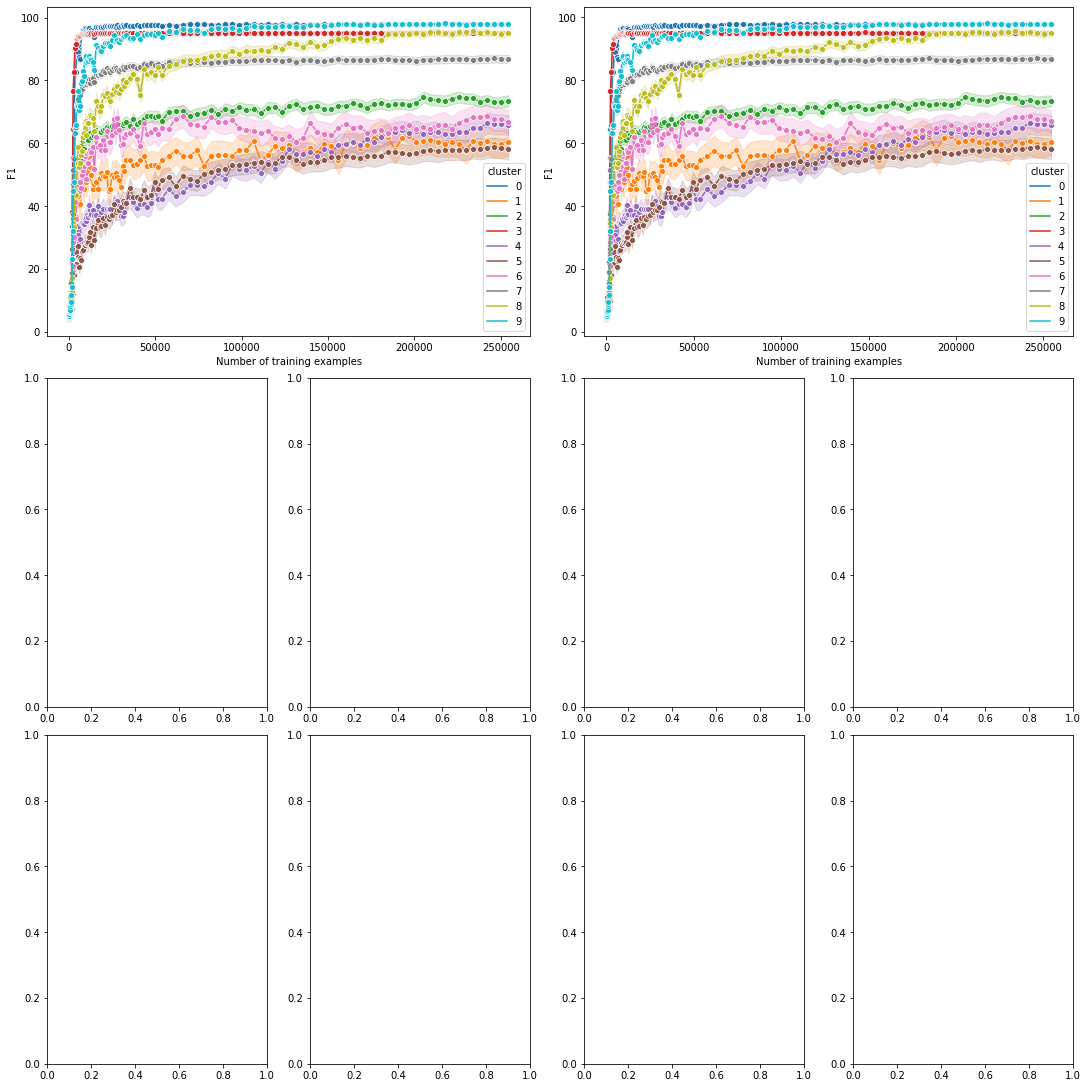

In [20]:
fig = plt.figure(constrained_layout=True, figsize=(15, 15))
gs = fig.add_gridspec(3, 4)
f_ax1 = fig.add_subplot(gs[0, :2])  # Full trajectory
f_ax2 = fig.add_subplot(gs[0, 2:])  # <2.5k
f_ax3 = fig.add_subplot(gs[1, 0])  # Pie chart 1
f_ax4 = fig.add_subplot(gs[1, 1])  # Pie chart 2
f_ax5 = fig.add_subplot(gs[1, 2])  # Pie chart 3
f_ax6 = fig.add_subplot(gs[1, 3])  # Pie chart 4
f_ax7 = fig.add_subplot(gs[2, 0])  # Pie chart 5
f_ax8 = fig.add_subplot(gs[2, 1])  # Pie chart 6
f_ax9 = fig.add_subplot(gs[2, 2])  # Pie chart 7
f_ax10 = fig.add_subplot(gs[2, 3])  # Pie chart 8 (Blank)

plot_df = per_example_metrics_df.copy()

# Full trajectory
sns.lineplot(
    data=plot_df, 
    x='num_examples', 
    y='f1', 
    hue='KM_label',
    palette='tab10',
    marker='o',
    ax=f_ax1
)
f_ax1.set_ylabel('F1')
f_ax1.set_xlabel('Number of training examples')
f_ax1.legend(title='cluster')

# <5k
sns.lineplot(
    data=plot_df,  #[plot_df['num_examples']< 5000], 
    x='num_examples', 
    y='f1', 
    hue='KM_label',
    palette='tab10',
    marker='o',
    ax=f_ax2
)
f_ax2.set_ylabel('F1')
f_ax2.set_xlabel('Number of training examples')
f_ax2.legend(title='cluster')

# Pie charts

# subset = plot_df.copy()[['id', 'dataset', 'KM_label']].drop_duplicates()  # Duplicated due to multiple checkpoints

# f_ax3.pie(
#     x=subset[subset['KM_label'] == 0].groupby('dataset')['id'].count().reset_index()['id'],
#     labels=subset[subset['KM_label'] == 0].groupby('dataset')['id'].count().reset_index()['dataset']
# )
# n = subset[subset['KM_label'] == 0].shape[0]
# f_ax3.set_title(f'cluster 0 (n={n})')

# f_ax4.pie(
#     x=subset[subset['KM_label'] == 1].groupby('dataset')['id'].count().reset_index()['id'],
#     labels=subset[subset['KM_label'] == 1].groupby('dataset')['id'].count().reset_index()['dataset']
# )
# n = subset[subset['KM_label'] == 1].shape[0]
# f_ax4.set_title(f'cluster 1 (n={n})')

# f_ax5.pie(
#     x=subset[subset['KM_label'] == 2].groupby('dataset')['id'].count().reset_index()['id'],
#     labels=subset[subset['KM_label'] == 2].groupby('dataset')['id'].count().reset_index()['dataset']
# )
# n = subset[subset['KM_label'] == 2].shape[0]
# f_ax5.set_title(f'cluster 2 (n={n})')

# f_ax6.pie(
#     x=subset[subset['KM_label'] == 3].groupby('dataset')['id'].count().reset_index()['id'],
#     labels=subset[subset['KM_label'] == 3].groupby('dataset')['id'].count().reset_index()['dataset']
# )
# n = subset[subset['KM_label'] == 3].shape[0]
# f_ax6.set_title(f'cluster 3 (n={n})')

# f_ax7.pie(
#     x=subset[subset['KM_label'] == 4].groupby('dataset')['id'].count().reset_index()['id'],
#     labels=subset[subset['KM_label'] == 4].groupby('dataset')['id'].count().reset_index()['dataset']
# )
# n = subset[subset['KM_label'] == 4].shape[0]
# f_ax7.set_title(f'cluster 4 (n={n})')

# f_ax8.pie(
#     x=subset[subset['KM_label'] == 5].groupby('dataset')['id'].count().reset_index()['id'],
#     labels=subset[subset['KM_label'] == 5].groupby('dataset')['id'].count().reset_index()['dataset']
# )
# n = subset[subset['KM_label'] == 5].shape[0]
# f_ax8.set_title(f'cluster 5 (n={n})')

# f_ax9.pie(
#     x=subset[subset['KM_label'] == 6].groupby('dataset')['id'].count().reset_index()['id'],
#     labels=subset[subset['KM_label'] == 6].groupby('dataset')['id'].count().reset_index()['dataset']
# )
# n = subset[subset['KM_label'] == 6].shape[0]
# f_ax9.set_title(f'cluster 6 (n={n})')

# # blank
# f_ax10.axis('off')

# plt.savefig(f'reports/figures/confidence-clusters-with-f1.pdf')
plt.show()

In [16]:
f1_cluster_labels = pd.read_csv('data/processed/squadv1-adversarialall-clusters-seed=27-km_seed=27-n_clusters=7.csv')
print(f1_cluster_labels.shape)
f1_cluster_labels.head()

(13570, 4)


,id,KM_label,km_seed,model_seed
0,000bcf40cda48527886c945b612c0c54ed46dff8,5,27,27
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,2,27,27
2,00245d3e103a58ff1e76c4996721a03a70412422,1,27,27
3,004241bb0375392cd909e85aeedbdf9b2f899def,1,27,27
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,3,27,27


In [17]:
f1_cluster_labels.rename(columns={'KM_label': 'KM_label_F1'}, inplace=True)

In [18]:
per_example_confidences_df = per_example_confidences_df.merge(f1_cluster_labels[['id', 'model_seed', 'KM_label_F1']], on=['id', 'model_seed'])
print(per_example_confidences_df.shape)
per_example_confidences_df.head()

(1628400, 17)


,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset,KM_label,km_seed,model_seed,f1,num_examples,KM_label_F1
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.002803,", twice the figure for the average profession",0.340419,1,27,dbert,2,27,27,57.142857,32,2
1,21a3561031f2e909338196601f5c1ac2e08905b6,1.206936,1.241911,0.004633,0.006071,0.002813,", twice the figure for the average profession",0.340258,2,27,dbert,2,27,27,57.142857,64,2
2,21a3561031f2e909338196601f5c1ac2e08905b6,1.206936,1.241911,0.004633,0.006071,0.002813,", twice the figure for the average profession",0.340258,3,27,dbert,2,27,27,57.142857,96,2
3,21a3561031f2e909338196601f5c1ac2e08905b6,1.201317,1.236228,0.004631,0.006118,0.002833,", twice the figure for the average profession",0.340248,4,27,dbert,2,27,27,57.142857,128,2
4,21a3561031f2e909338196601f5c1ac2e08905b6,1.200890,1.225830,0.004659,0.006188,0.002883,the average profession,0.342598,5,27,dbert,2,27,27,100.000000,160,2


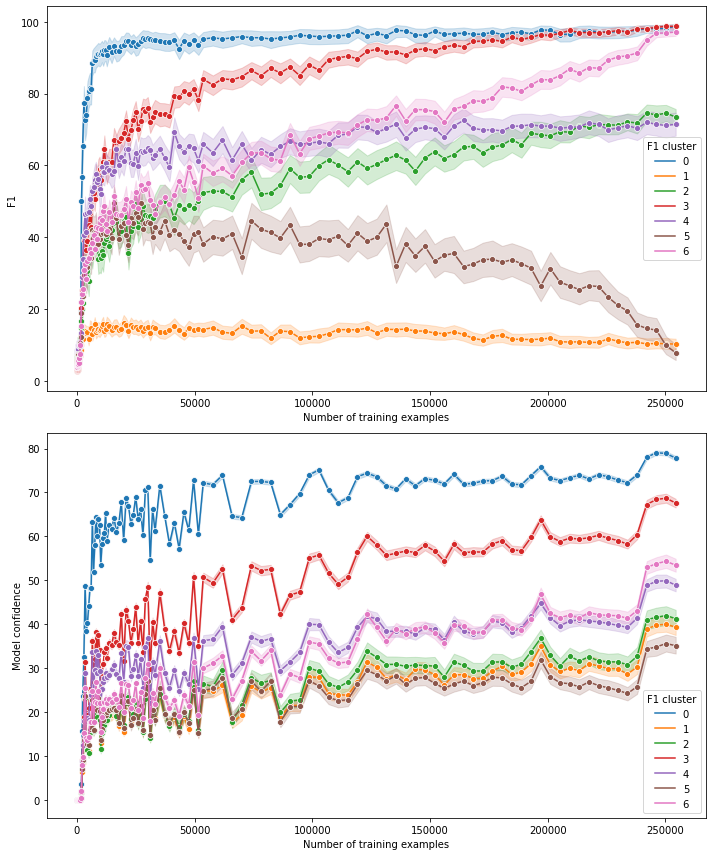

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# F1 trajectories by F1 cluster
sns.lineplot(
    data=per_example_confidences_df, 
    x='num_examples', 
    y='f1', 
    hue='KM_label_F1',
    palette='tab10',
    marker='o',
    ax=axs[0]
)
axs[0].set_ylabel('F1')
axs[0].set_xlabel('Number of training examples')
axs[0].legend(title='F1 cluster')

# Confidence trajectories by F1 cluster
sns.lineplot(
    data=per_example_confidences_df, 
    x='num_examples', 
    y='model_conf', 
    hue='KM_label_F1',
    palette='tab10',
    marker='o',
    ax=axs[1]
)
axs[1].set_ylabel('Model confidence')
axs[1].set_xlabel('Number of training examples')
axs[1].legend(title='F1 cluster')

plt.tight_layout()
plt.savefig(f'reports/figures/f1-clusters-with-confidence.pdf')
plt.show()

## Other plots

### 10 cluster

In [1]:
import os
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('../..')

In [3]:
from src.models.kmeans_conf import load_per_example_confidences_df

/home/sgeorge/.conda/envs/rclearn/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
BATCH_SIZE = 32

In [5]:
per_example_confidences_df = load_per_example_confidences_df(seed=27)

2021-09-01 00:38:02,724 - Loading predictions data
2021-09-01 00:38:26,093 - Loading predictions data
2021-09-01 00:38:42,139 - Loading predictions data
2021-09-01 00:39:03,924 - Loading predictions data
2021-09-01 00:40:48,390 - (1628400, 11)


In [6]:
per_example_confidences_df.head()

,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.000028,", twice the figure for the average profession",0.340419,1,27,dbert
1,b6a71a728a35506dd4cd2179c9342acf5e1a047a,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert
2,6febf2fec8ae1b105a1b955897415fea4b2c0c28,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert
3,53e4ce951aeab3a2712aa0966d73ec3e2c62ca11,1.075523,1.030129,0.004833,0.004892,0.000024,42% of UK teachers experienced occupational st...,0.508334,1,27,dbert
4,a0a308febc5e9edf56fe63556cf20c039c3fdaca,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert


### 10 clusters

In [7]:
clusters_df = pd.read_csv('data/processed/squadv1-adversarialall-confidence-clusters-seed=27-km_seed=27-n_clusters=10.csv')
print(clusters_df.shape)
clusters_df.head()

(13570, 4)


,id,KM_label,km_seed,model_seed
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,27,27
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,5,27,27
2,00245d3e103a58ff1e76c4996721a03a70412422,1,27,27
3,004241bb0375392cd909e85aeedbdf9b2f899def,5,27,27
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,6,27,27


In [8]:
clusters_df['KM_label'].nunique()

10

In [9]:
per_example_confidences_df = per_example_confidences_df.merge(clusters_df, left_on=['id', 'seed'], right_on=['id', 'model_seed'])
print(per_example_confidences_df.shape)
per_example_confidences_df.head()

(1628400, 14)


,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset,KM_label,km_seed,model_seed
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.000028,", twice the figure for the average profession",0.340419,1,27,dbert,8,27,27
1,21a3561031f2e909338196601f5c1ac2e08905b6,1.206936,1.241911,0.004633,0.006071,0.000028,", twice the figure for the average profession",0.340258,2,27,dbert,8,27,27
2,21a3561031f2e909338196601f5c1ac2e08905b6,1.206936,1.241911,0.004633,0.006071,0.000028,", twice the figure for the average profession",0.340258,3,27,dbert,8,27,27
3,21a3561031f2e909338196601f5c1ac2e08905b6,1.201317,1.236228,0.004631,0.006118,0.000028,", twice the figure for the average profession",0.340248,4,27,dbert,8,27,27
4,21a3561031f2e909338196601f5c1ac2e08905b6,1.200890,1.225830,0.004659,0.006188,0.000029,the average profession,0.342598,5,27,dbert,8,27,27


In [10]:
f1_df = pd.DataFrame()

for dataset in ['dbert', 'dbidaf', 'droberta']:
    df = pd.read_csv(f'data/processed/per_example_metrics-squadv1-adversarialall-dataset={dataset}-seed=27.csv')
    f1_df = f1_df.append(df, ignore_index=True)
    
print(f1_df.shape)
f1_df.head()

(360000, 6)


,id,checkpoint,seed,exact_match,f1,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,2956,27,100.0,100.000000,dbert
1,21a3561031f2e909338196601f5c1ac2e08905b6,684,27,0.0,36.363636,dbert
2,21a3561031f2e909338196601f5c1ac2e08905b6,44,27,0.0,0.000000,dbert
3,21a3561031f2e909338196601f5c1ac2e08905b6,10,27,100.0,100.000000,dbert
4,21a3561031f2e909338196601f5c1ac2e08905b6,876,27,0.0,44.444444,dbert


In [11]:
per_example_confidences_df = per_example_confidences_df.merge(f1_df[['id', 'checkpoint', 'seed', 'f1']], on=['id', 'checkpoint', 'seed'], how='left')
print(per_example_confidences_df.shape)
per_example_confidences_df.head()

(1628400, 15)


,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset,KM_label,km_seed,model_seed,f1
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.000028,", twice the figure for the average profession",0.340419,1,27,dbert,8,27,27,57.142857
1,21a3561031f2e909338196601f5c1ac2e08905b6,1.206936,1.241911,0.004633,0.006071,0.000028,", twice the figure for the average profession",0.340258,2,27,dbert,8,27,27,57.142857
2,21a3561031f2e909338196601f5c1ac2e08905b6,1.206936,1.241911,0.004633,0.006071,0.000028,", twice the figure for the average profession",0.340258,3,27,dbert,8,27,27,57.142857
3,21a3561031f2e909338196601f5c1ac2e08905b6,1.201317,1.236228,0.004631,0.006118,0.000028,", twice the figure for the average profession",0.340248,4,27,dbert,8,27,27,57.142857
4,21a3561031f2e909338196601f5c1ac2e08905b6,1.200890,1.225830,0.004659,0.006188,0.000029,the average profession,0.342598,5,27,dbert,8,27,27,100.000000


In [12]:
per_example_confidences_df['num_examples'] = per_example_confidences_df['checkpoint'] * BATCH_SIZE

Confidence trajectories by confidence cluster

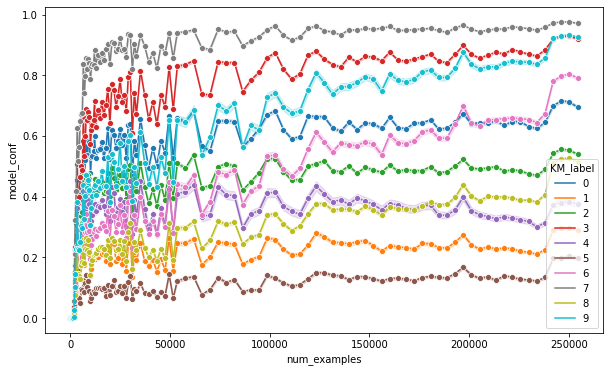

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=per_example_confidences_df, 
    x='num_examples', 
    y='model_conf', 
    hue='KM_label',
    palette='tab10',
    marker='o',
    ax=ax
)
plt.show()

F1 trajectories by confidence cluster

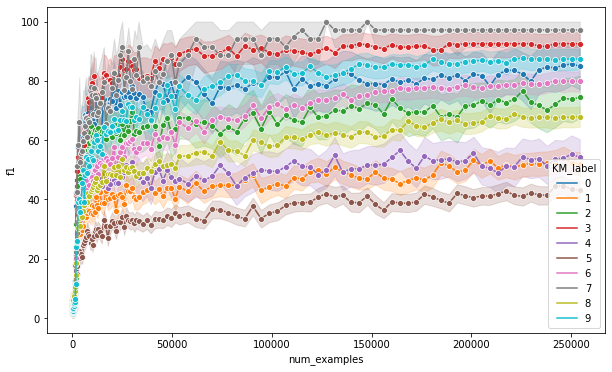

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=per_example_confidences_df, 
    x='num_examples', 
    y='f1', 
    hue='KM_label',
    palette='tab10',
    marker='o',
    ax=ax
)
plt.show()

In [15]:
f1_cluster_labels = pd.read_csv('data/processed/squadv1-adversarialall-clusters-seed=27-km_seed=27-n_clusters=10.csv')
print(f1_cluster_labels.shape)
f1_cluster_labels.head()

(13570, 4)


,id,KM_label,km_seed,model_seed
0,000bcf40cda48527886c945b612c0c54ed46dff8,9,27,27
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,4,27,27
2,00245d3e103a58ff1e76c4996721a03a70412422,1,27,27
3,004241bb0375392cd909e85aeedbdf9b2f899def,1,27,27
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,3,27,27


In [16]:
f1_cluster_labels.rename(columns={'KM_label': 'KM_label_F1'}, inplace=True)

In [17]:
per_example_confidences_df = per_example_confidences_df.merge(f1_cluster_labels[['id', 'model_seed', 'KM_label_F1']], on=['id', 'model_seed'])
print(per_example_confidences_df.shape)
per_example_confidences_df.head()

(1628400, 17)


,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset,KM_label,km_seed,model_seed,f1,num_examples,KM_label_F1
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.000028,", twice the figure for the average profession",0.340419,1,27,dbert,8,27,27,57.142857,32,8
1,21a3561031f2e909338196601f5c1ac2e08905b6,1.206936,1.241911,0.004633,0.006071,0.000028,", twice the figure for the average profession",0.340258,2,27,dbert,8,27,27,57.142857,64,8
2,21a3561031f2e909338196601f5c1ac2e08905b6,1.206936,1.241911,0.004633,0.006071,0.000028,", twice the figure for the average profession",0.340258,3,27,dbert,8,27,27,57.142857,96,8
3,21a3561031f2e909338196601f5c1ac2e08905b6,1.201317,1.236228,0.004631,0.006118,0.000028,", twice the figure for the average profession",0.340248,4,27,dbert,8,27,27,57.142857,128,8
4,21a3561031f2e909338196601f5c1ac2e08905b6,1.200890,1.225830,0.004659,0.006188,0.000029,the average profession,0.342598,5,27,dbert,8,27,27,100.000000,160,8


F1 trajectories by F1 cluster

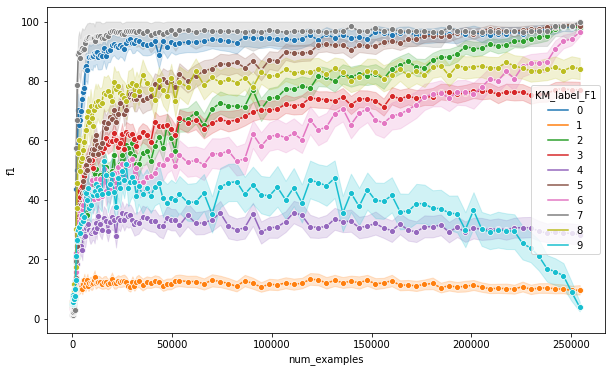

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=per_example_confidences_df, 
    x='num_examples', 
    y='f1', 
    hue='KM_label_F1',
    palette='tab10',
    marker='o',
    ax=ax
)
plt.show()

Confidence trajectories by F1 cluster

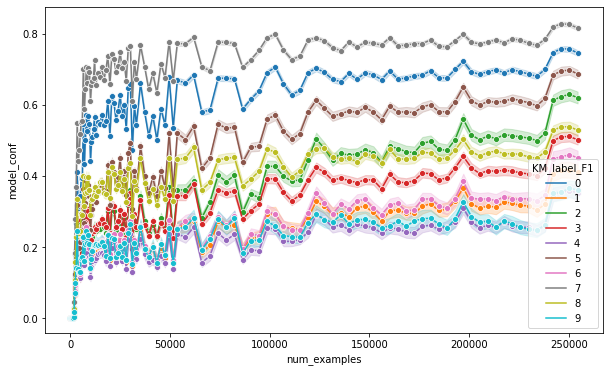

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=per_example_confidences_df, 
    x='num_examples', 
    y='model_conf', 
    hue='KM_label_F1',
    palette='tab10',
    marker='o',
    ax=ax
)
plt.show()

### 4 cluster

In [1]:
import os
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('../..')

In [3]:
from src.models.kmeans_conf import load_per_example_confidences_df

/home/sgeorge/.conda/envs/rclearn/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
BATCH_SIZE = 32

In [5]:
per_example_confidences_df = load_per_example_confidences_df(seed=27)

2021-09-01 00:48:46,396 - Loading predictions data
2021-09-01 00:49:02,532 - Loading predictions data
2021-09-01 00:49:13,622 - Loading predictions data
2021-09-01 00:49:25,788 - Loading predictions data
2021-09-01 00:50:42,404 - (1628400, 11)


In [6]:
per_example_confidences_df.head()

,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.000028,", twice the figure for the average profession",0.340419,1,27,dbert
1,b6a71a728a35506dd4cd2179c9342acf5e1a047a,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert
2,6febf2fec8ae1b105a1b955897415fea4b2c0c28,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert
3,53e4ce951aeab3a2712aa0966d73ec3e2c62ca11,1.075523,1.030129,0.004833,0.004892,0.000024,42% of UK teachers experienced occupational st...,0.508334,1,27,dbert
4,a0a308febc5e9edf56fe63556cf20c039c3fdaca,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert


### 4 clusters

In [7]:
clusters_df = pd.read_csv('data/processed/squadv1-adversarialall-confidence-clusters-seed=27-km_seed=27-n_clusters=4.csv')
print(clusters_df.shape)
clusters_df.head()

(13570, 4)


,id,KM_label,km_seed,model_seed
0,000bcf40cda48527886c945b612c0c54ed46dff8,1,27,27
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,1,27,27
2,00245d3e103a58ff1e76c4996721a03a70412422,1,27,27
3,004241bb0375392cd909e85aeedbdf9b2f899def,1,27,27
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,0,27,27


In [8]:
clusters_df['KM_label'].nunique()

4

In [9]:
per_example_confidences_df = per_example_confidences_df.merge(clusters_df, left_on=['id', 'seed'], right_on=['id', 'model_seed'])
print(per_example_confidences_df.shape)
per_example_confidences_df.head()

(1628400, 14)


,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset,KM_label,km_seed,model_seed
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.000028,", twice the figure for the average profession",0.340419,1,27,dbert,2,27,27
1,21a3561031f2e909338196601f5c1ac2e08905b6,1.206936,1.241911,0.004633,0.006071,0.000028,", twice the figure for the average profession",0.340258,2,27,dbert,2,27,27
2,21a3561031f2e909338196601f5c1ac2e08905b6,1.206936,1.241911,0.004633,0.006071,0.000028,", twice the figure for the average profession",0.340258,3,27,dbert,2,27,27
3,21a3561031f2e909338196601f5c1ac2e08905b6,1.201317,1.236228,0.004631,0.006118,0.000028,", twice the figure for the average profession",0.340248,4,27,dbert,2,27,27
4,21a3561031f2e909338196601f5c1ac2e08905b6,1.200890,1.225830,0.004659,0.006188,0.000029,the average profession,0.342598,5,27,dbert,2,27,27


In [10]:
f1_df = pd.DataFrame()

for dataset in ['dbert', 'dbidaf', 'droberta']:
    df = pd.read_csv(f'data/processed/per_example_metrics-squadv1-adversarialall-dataset={dataset}-seed=27.csv')
    f1_df = f1_df.append(df, ignore_index=True)
    
print(f1_df.shape)
f1_df.head()

(360000, 6)


,id,checkpoint,seed,exact_match,f1,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,2956,27,100.0,100.000000,dbert
1,21a3561031f2e909338196601f5c1ac2e08905b6,684,27,0.0,36.363636,dbert
2,21a3561031f2e909338196601f5c1ac2e08905b6,44,27,0.0,0.000000,dbert
3,21a3561031f2e909338196601f5c1ac2e08905b6,10,27,100.0,100.000000,dbert
4,21a3561031f2e909338196601f5c1ac2e08905b6,876,27,0.0,44.444444,dbert


In [11]:
per_example_confidences_df = per_example_confidences_df.merge(f1_df[['id', 'checkpoint', 'seed', 'f1']], on=['id', 'checkpoint', 'seed'], how='left')
print(per_example_confidences_df.shape)
per_example_confidences_df.head()

(1628400, 15)


,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset,KM_label,km_seed,model_seed,f1
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.000028,", twice the figure for the average profession",0.340419,1,27,dbert,2,27,27,57.142857
1,21a3561031f2e909338196601f5c1ac2e08905b6,1.206936,1.241911,0.004633,0.006071,0.000028,", twice the figure for the average profession",0.340258,2,27,dbert,2,27,27,57.142857
2,21a3561031f2e909338196601f5c1ac2e08905b6,1.206936,1.241911,0.004633,0.006071,0.000028,", twice the figure for the average profession",0.340258,3,27,dbert,2,27,27,57.142857
3,21a3561031f2e909338196601f5c1ac2e08905b6,1.201317,1.236228,0.004631,0.006118,0.000028,", twice the figure for the average profession",0.340248,4,27,dbert,2,27,27,57.142857
4,21a3561031f2e909338196601f5c1ac2e08905b6,1.200890,1.225830,0.004659,0.006188,0.000029,the average profession,0.342598,5,27,dbert,2,27,27,100.000000


In [12]:
per_example_confidences_df['num_examples'] = per_example_confidences_df['checkpoint'] * BATCH_SIZE

Confidence trajectories by confidence cluster

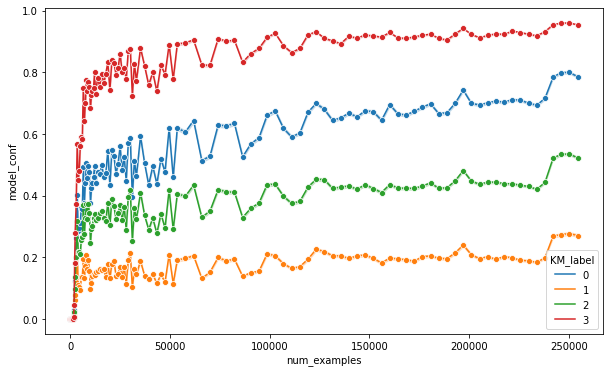

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=per_example_confidences_df, 
    x='num_examples', 
    y='model_conf', 
    hue='KM_label',
    palette='tab10',
    marker='o',
    ax=ax
)
plt.show()

F1 trajectories by confidence cluster

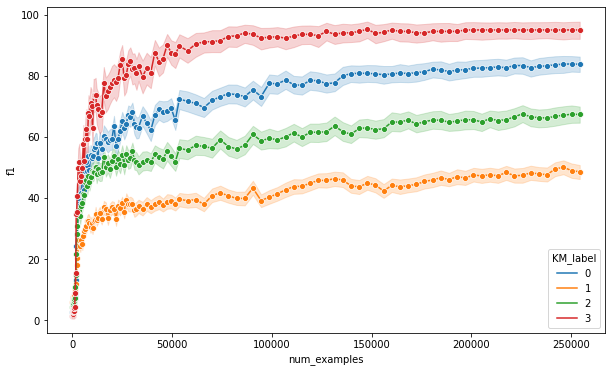

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=per_example_confidences_df, 
    x='num_examples', 
    y='f1', 
    hue='KM_label',
    palette='tab10',
    marker='o',
    ax=ax
)
plt.show()

In [15]:
f1_cluster_labels = pd.read_csv('data/processed/squadv1-adversarialall-clusters-seed=27-km_seed=27-n_clusters=4.csv')
print(f1_cluster_labels.shape)
f1_cluster_labels.head()

(13570, 4)


,id,KM_label,km_seed,model_seed
0,000bcf40cda48527886c945b612c0c54ed46dff8,2,27,27
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,3,27,27
2,00245d3e103a58ff1e76c4996721a03a70412422,1,27,27
3,004241bb0375392cd909e85aeedbdf9b2f899def,1,27,27
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,3,27,27


In [16]:
f1_cluster_labels.rename(columns={'KM_label': 'KM_label_F1'}, inplace=True)

In [17]:
per_example_confidences_df = per_example_confidences_df.merge(f1_cluster_labels[['id', 'model_seed', 'KM_label_F1']], on=['id', 'model_seed'])
print(per_example_confidences_df.shape)
per_example_confidences_df.head()

(1628400, 17)


,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset,KM_label,km_seed,model_seed,f1,num_examples,KM_label_F1
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.000028,", twice the figure for the average profession",0.340419,1,27,dbert,2,27,27,57.142857,32,3
1,21a3561031f2e909338196601f5c1ac2e08905b6,1.206936,1.241911,0.004633,0.006071,0.000028,", twice the figure for the average profession",0.340258,2,27,dbert,2,27,27,57.142857,64,3
2,21a3561031f2e909338196601f5c1ac2e08905b6,1.206936,1.241911,0.004633,0.006071,0.000028,", twice the figure for the average profession",0.340258,3,27,dbert,2,27,27,57.142857,96,3
3,21a3561031f2e909338196601f5c1ac2e08905b6,1.201317,1.236228,0.004631,0.006118,0.000028,", twice the figure for the average profession",0.340248,4,27,dbert,2,27,27,57.142857,128,3
4,21a3561031f2e909338196601f5c1ac2e08905b6,1.200890,1.225830,0.004659,0.006188,0.000029,the average profession,0.342598,5,27,dbert,2,27,27,100.000000,160,3


F1 trajectories by F1 cluster

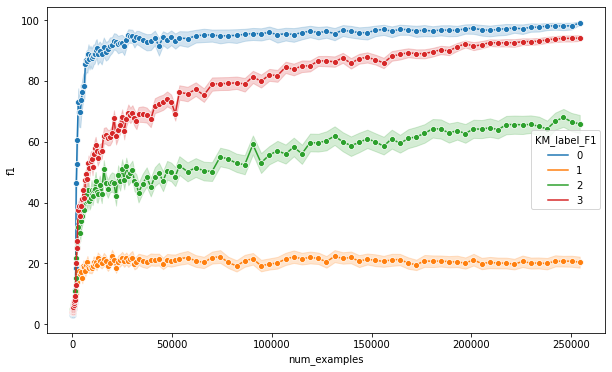

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=per_example_confidences_df, 
    x='num_examples', 
    y='f1', 
    hue='KM_label_F1',
    palette='tab10',
    marker='o',
    ax=ax
)
plt.show()

Confidence trajectories by F1 cluster

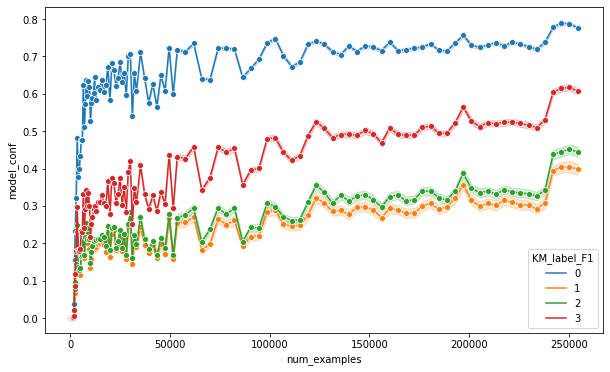

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=per_example_confidences_df, 
    x='num_examples', 
    y='model_conf', 
    hue='KM_label_F1',
    palette='tab10',
    marker='o',
    ax=ax
)
plt.show()

In [27]:
per_example_confidences_df[per_example_confidences_df['KM_label'] == 3]['dataset'].value_counts() / per_example_confidences_df[per_example_confidences_df['KM_label'] == 3]['dataset'].value_counts().sum()

squad       0.942212
dbidaf      0.026417
dbert       0.018162
droberta    0.013209
Name: dataset, dtype: float64

In [25]:
per_example_confidences_df[per_example_confidences_df['KM_label'] == 1]['dataset'].value_counts() / per_example_confidences_df[per_example_confidences_df['KM_label'] == 1]['dataset'].value_counts().sum()

squad       0.507474
droberta    0.192451
dbert       0.159567
dbidaf      0.140508
Name: dataset, dtype: float64

In [4]:
def create_filepath_dict_full(model_filepath: str) -> dict:
    """
    Filepath dict for full predictions incl. model confidences
    
    :param model_filepath: Filepath containing model checkpoints
    :return: Dict with checkpoint numbers as keys and corresponding path as values
    """
    checkpoint_str = list(
        os.walk(model_filepath)
    )[0][1]

    checkpoint_nbr = [int(x.split('-')[-1]) for x in checkpoint_str]
    
    checkpoint_fp = [f'{model_filepath}/{x}/eval_predictions_full.json' for x in checkpoint_str]

    prediction_filepath_dict = dict(zip(checkpoint_nbr, checkpoint_fp))

    return prediction_filepath_dict

In [5]:
def generate_predictions_df_full(model_filepath: str, seed: int):
    """
    Generate DataFrame of predictions by checkpoint and seed from raw JSON output files (incl. model confidences)
    """
    logging.info('Loading predictions data')
    prediction_filepath_dict = create_filepath_dict_full(model_filepath)

    predictions_df = pd.DataFrame()

    for checkpoint, fp in prediction_filepath_dict.items():
        eval_predictions_df = pd.read_json(fp, orient='index').reset_index()
        eval_predictions_df.rename(columns={'index': 'id'}, inplace=True)
        eval_predictions_df['checkpoint'] = checkpoint
        eval_predictions_df['seed'] = seed

        predictions_df = predictions_df.append(eval_predictions_df)

    return predictions_df

In [6]:
seed = 27

dataset_to_fp = {
    'dbert': 'predictions/full/albert-xlarge-v2-squadv1-adversarialall-wu=100-lr=3e5-bs=32-msl=384-seed=27-dbert',
    'dbidaf': 'predictions/full/albert-xlarge-v2-squadv1-adversarialall-wu=100-lr=3e5-bs=32-msl=384-seed=27-dbidaf',
    'droberta': 'predictions/full/albert-xlarge-v2-squadv1-adversarialall-wu=100-lr=3e5-bs=32-msl=384-seed=27-droberta',
    'squad': 'predictions/full/albert-xlarge-v2-squadv1-adversarialall-wu=100-lr=3e5-bs=32-msl=384-seed=27-squad',
}

In [7]:
all_predictions_df = pd.DataFrame()

for dataset, model_filepath in dataset_to_fp.items():
    predictions_df = generate_predictions_df_full(model_filepath=model_filepath, seed=seed)
    predictions_df['dataset'] = dataset
    print(predictions_df.shape)
    
    all_predictions_df = all_predictions_df.append(predictions_df, ignore_index=True)
    
print(all_predictions_df.shape)
all_predictions_df.head()

2021-08-31 16:42:39,445 - Loading predictions data
2021-08-31 16:42:45,324 - Loading predictions data


(120000, 11)


2021-08-31 16:42:49,531 - Loading predictions data


(120000, 11)


2021-08-31 16:42:54,930 - Loading predictions data


(120000, 11)
(1268400, 11)
(1628400, 11)


,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.000028,", twice the figure for the average profession",0.340419,1,27,dbert
1,b6a71a728a35506dd4cd2179c9342acf5e1a047a,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,empty,1.000000,1,27,dbert
2,6febf2fec8ae1b105a1b955897415fea4b2c0c28,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,empty,1.000000,1,27,dbert
3,53e4ce951aeab3a2712aa0966d73ec3e2c62ca11,1.075523,1.030129,0.004833,0.004892,0.000024,42% of UK teachers experienced occupational st...,0.508334,1,27,dbert
4,a0a308febc5e9edf56fe63556cf20c039c3fdaca,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,empty,1.000000,1,27,dbert


In [8]:
assert all_predictions_df.shape[0] == 120*(1000*3+10570)

In [9]:
predictions_df.isnull().sum()

id                  0
start_logit         0
end_logit           0
model_conf_start    0
model_conf_end      0
model_conf          0
text                0
probability         0
checkpoint          0
seed                0
dataset             0
dtype: int64

In [10]:
all_predictions_df['model_conf'] = np.where(
    all_predictions_df['model_conf'] == -1,
    0,
    all_predictions_df['model_conf']
)

In [11]:
all_predictions_df.head()

,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.000028,", twice the figure for the average profession",0.340419,1,27,dbert
1,b6a71a728a35506dd4cd2179c9342acf5e1a047a,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert
2,6febf2fec8ae1b105a1b955897415fea4b2c0c28,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert
3,53e4ce951aeab3a2712aa0966d73ec3e2c62ca11,1.075523,1.030129,0.004833,0.004892,0.000024,42% of UK teachers experienced occupational st...,0.508334,1,27,dbert
4,a0a308febc5e9edf56fe63556cf20c039c3fdaca,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert


In [12]:
all_predictions_df['id'].nunique()

13570

In [26]:
# from tqdm import tqdm
# from tslearn.clustering import TimeSeriesKMeans

# def _prepare_data(per_example_metrics_df: pd.DataFrame, value: str = 'f1') -> (np.array, dict):
#     """
#     Prepare input array for k-means. Input is of dim (n_ts, sz, d) where n_ts=number of time series; sz=length of
#     time series; d=dimensionality of time series
#     :param per_example_metrics_df:
#     :return:
#     """
#     logging.info('Preparing input for k-means')
#     per_example_metrics_df = per_example_metrics_df.copy()
#     per_example_metrics_df.sort_values(['id', 'checkpoint'], inplace=True)

#     n_ts = per_example_metrics_df['id'].nunique()
# #     assert n_ts == np.sum(list(DEV_DATA_SIZES.values()))
#     sz = 120
#     d = 1

#     X = np.zeros((n_ts, sz, d))

#     # Store mapping for index position to corresponding ID
#     idx_to_id_dict = {}

#     for idx, _id in tqdm(
#             enumerate(per_example_metrics_df['id'].unique()),
#             total=per_example_metrics_df['id'].nunique()
#     ):

#         idx_to_id_dict[idx] = _id

#         X[idx, :, :] = per_example_metrics_df[per_example_metrics_df['id'] == _id][value].values.reshape(-1, 1)

#     logging.info(X.shape)

#     return X, idx_to_id_dict

# def get_kmeans_clusters(
#         per_example_metrics_df: pd.DataFrame,
#         n_clusters: int,
#         model_seed: int,
#         km_seed: int,
#         value: str = 'f1',
#         max_iter: int = 300
# ) -> pd.DataFrame:

#     X, idx_to_id_dict = _prepare_data(per_example_metrics_df, value=value)

#     # Fit K-means
#     logging.info('Fitting k-means')
#     km = TimeSeriesKMeans(
#         n_clusters=n_clusters,
#         metric="dtw",
#         max_iter=max_iter,
#         random_state=km_seed,
#         verbose=0,
#         n_jobs=-1
#     )
#     labels = km.fit_predict(X)
#     logging.info('Finished k-means')
#     logging.info('Processing labels')

#     id_km_labels = []
#     for idx, _id in idx_to_id_dict.items():
#         id_km_labels.append((_id, labels[idx]))

#     id_km_labels_df = pd.DataFrame(id_km_labels, columns=['id', 'KM_label'])
# #     assert id_km_labels_df.shape[0] == np.sum(list(DEV_DATA_SIZES.values()))

#     id_km_labels_df['km_seed'] = km_seed
#     id_km_labels_df['model_seed'] = model_seed

#     logging.info(id_km_labels_df.shape)
#     logging.info(id_km_labels_df.head())

#     return id_km_labels_df

In [29]:
%%time
id_km_labels_df = get_kmeans_clusters(all_predictions_df[all_predictions_df['dataset'] != 'squad'], n_clusters=7, model_seed=seed, km_seed=seed, value='model_conf', max_iter=3)

2021-08-31 17:02:34,015 - Preparing input for k-means
100%|██████████| 3000/3000 [04:12<00:00, 11.90it/s]
2021-08-31 17:06:47,629 - (3000, 120, 1)
2021-08-31 17:06:47,674 - Fitting k-means
2021-08-31 17:09:11,711 - Finished k-means
2021-08-31 17:09:11,713 - Processing labels
2021-08-31 17:09:11,723 - (3000, 4)
2021-08-31 17:09:11,725 -                                          id  KM_label  km_seed  model_seed
0  000bcf40cda48527886c945b612c0c54ed46dff8         5       27          27
1  001a30863d32440f80d5f4f65e7bb3ee0698f0a0         2       27          27
2  00245d3e103a58ff1e76c4996721a03a70412422         5       27          27
3  004241bb0375392cd909e85aeedbdf9b2f899def         2       27          27
4  0054d06bf3be61edaa33f71cf897f98a37e73ea8         6       27          27


CPU times: user 6min 48s, sys: 14.9 s, total: 7min 3s
Wall time: 6min 38s


In [30]:
id_km_labels_df.head()

,id,KM_label,km_seed,model_seed
0,000bcf40cda48527886c945b612c0c54ed46dff8,5,27,27
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,2,27,27
2,00245d3e103a58ff1e76c4996721a03a70412422,5,27,27
3,004241bb0375392cd909e85aeedbdf9b2f899def,2,27,27
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,6,27,27


In [33]:
plot_df = all_predictions_df.copy()[all_predictions_df['dataset'] != 'squad']
print(plot_df.shape)
plot_df.head()

(360000, 11)


,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.000028,", twice the figure for the average profession",0.340419,1,27,dbert
1,b6a71a728a35506dd4cd2179c9342acf5e1a047a,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert
2,6febf2fec8ae1b105a1b955897415fea4b2c0c28,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert
3,53e4ce951aeab3a2712aa0966d73ec3e2c62ca11,1.075523,1.030129,0.004833,0.004892,0.000024,42% of UK teachers experienced occupational st...,0.508334,1,27,dbert
4,a0a308febc5e9edf56fe63556cf20c039c3fdaca,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert


In [35]:
plot_df = plot_df.merge(id_km_labels_df, on='id', how='left')
plot_df.head()

,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset,KM_label,km_seed,model_seed
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.000028,", twice the figure for the average profession",0.340419,1,27,dbert,4,27,27
1,b6a71a728a35506dd4cd2179c9342acf5e1a047a,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert,5,27,27
2,6febf2fec8ae1b105a1b955897415fea4b2c0c28,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert,2,27,27
3,53e4ce951aeab3a2712aa0966d73ec3e2c62ca11,1.075523,1.030129,0.004833,0.004892,0.000024,42% of UK teachers experienced occupational st...,0.508334,1,27,dbert,2,27,27
4,a0a308febc5e9edf56fe63556cf20c039c3fdaca,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert,3,27,27


In [36]:
import seaborn as sns

1. Cluster by confidences

<AxesSubplot:xlabel='checkpoint', ylabel='model_conf'>

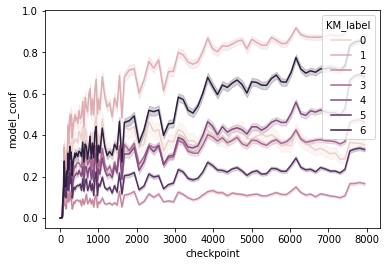

In [37]:
sns.lineplot(data=plot_df, y='model_conf', x='checkpoint', hue='KM_label')

2. For confidence clusters plot F1

In [40]:
f1_df = pd.DataFrame()

for dataset in ['dbert', 'dbidaf', 'droberta']:
    df = pd.read_csv(f'data/processed/per_example_metrics-squadv1-adversarialall-dataset={dataset}-seed=27.csv')
    f1_df = f1_df.append(df, ignore_index=True)
    
print(f1_df.shape)
f1_df.head()

(360000, 6)


,id,checkpoint,seed,exact_match,f1,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,2956,27,100.0,100.000000,dbert
1,21a3561031f2e909338196601f5c1ac2e08905b6,684,27,0.0,36.363636,dbert
2,21a3561031f2e909338196601f5c1ac2e08905b6,44,27,0.0,0.000000,dbert
3,21a3561031f2e909338196601f5c1ac2e08905b6,10,27,100.0,100.000000,dbert
4,21a3561031f2e909338196601f5c1ac2e08905b6,876,27,0.0,44.444444,dbert


In [43]:
plot_df = plot_df.merge(f1_df[['id', 'checkpoint', 'f1']], on=['id', 'checkpoint'])

In [44]:
plot_df.head()

,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset,KM_label,km_seed,model_seed,f1
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.000028,", twice the figure for the average profession",0.340419,1,27,dbert,4,27,27,57.142857
1,b6a71a728a35506dd4cd2179c9342acf5e1a047a,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert,5,27,27,0.000000
2,6febf2fec8ae1b105a1b955897415fea4b2c0c28,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert,2,27,27,0.000000
3,53e4ce951aeab3a2712aa0966d73ec3e2c62ca11,1.075523,1.030129,0.004833,0.004892,0.000024,42% of UK teachers experienced occupational st...,0.508334,1,27,dbert,2,27,27,0.000000
4,a0a308febc5e9edf56fe63556cf20c039c3fdaca,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert,3,27,27,0.000000


<AxesSubplot:xlabel='checkpoint', ylabel='f1'>

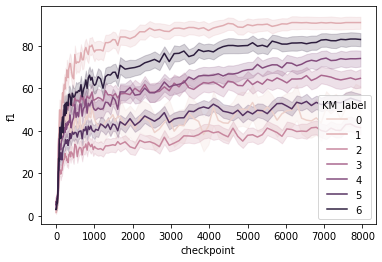

In [45]:
sns.lineplot(data=plot_df, y='f1', x='checkpoint', hue='KM_label')

<AxesSubplot:xlabel='model_conf', ylabel='f1'>

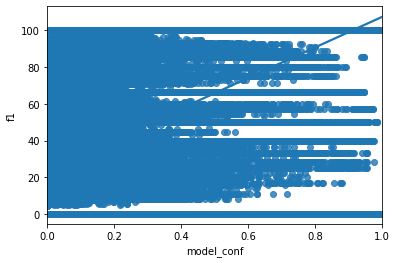

In [47]:
sns.regplot(data=plot_df, x='model_conf', y='f1')

3. Data maps approach (__paper uses prob of true label - can't replicate here__)

In [73]:
all_predictions_df.head()

,id,start_logit,end_logit,model_conf_start,model_conf_end,model_conf,text,probability,checkpoint,seed,dataset
0,21a3561031f2e909338196601f5c1ac2e08905b6,1.208647,1.245707,0.004629,0.006055,0.000028,", twice the figure for the average profession",0.340419,1,27,dbert
1,b6a71a728a35506dd4cd2179c9342acf5e1a047a,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert
2,6febf2fec8ae1b105a1b955897415fea4b2c0c28,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert
3,53e4ce951aeab3a2712aa0966d73ec3e2c62ca11,1.075523,1.030129,0.004833,0.004892,0.000024,42% of UK teachers experienced occupational st...,0.508334,1,27,dbert
4,a0a308febc5e9edf56fe63556cf20c039c3fdaca,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,empty,1.000000,1,27,dbert


In [74]:
model_conf_mean = all_predictions_df.groupby('id')['model_conf'].mean().reset_index()
model_conf_mean.rename(columns={'model_conf': 'model_conf_mean'}, inplace=True)
model_conf_mean.head()

,id,model_conf_mean
0,000bcf40cda48527886c945b612c0c54ed46dff8,0.190400
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,0.078484
2,00245d3e103a58ff1e76c4996721a03a70412422,0.150973
3,004241bb0375392cd909e85aeedbdf9b2f899def,0.112712
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,0.459248


In [75]:
model_conf_std = all_predictions_df.groupby('id')['model_conf'].std().reset_index()
model_conf_std.rename(columns={'model_conf': 'model_conf_std'}, inplace=True)
model_conf_std.head()

,id,model_conf_std
0,000bcf40cda48527886c945b612c0c54ed46dff8,0.164401
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,0.085923
2,00245d3e103a58ff1e76c4996721a03a70412422,0.149946
3,004241bb0375392cd909e85aeedbdf9b2f899def,0.108100
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,0.325201


In [76]:
data_map_df = model_conf_mean.merge(model_conf_std, on='id')
print(data_map_df.shape)
data_map_df.head()

(13570, 3)


,id,model_conf_mean,model_conf_std
0,000bcf40cda48527886c945b612c0c54ed46dff8,0.190400,0.164401
1,001a30863d32440f80d5f4f65e7bb3ee0698f0a0,0.078484,0.085923
2,00245d3e103a58ff1e76c4996721a03a70412422,0.150973,0.149946
3,004241bb0375392cd909e85aeedbdf9b2f899def,0.112712,0.108100
4,0054d06bf3be61edaa33f71cf897f98a37e73ea8,0.459248,0.325201


<AxesSubplot:xlabel='model_conf_std', ylabel='model_conf_mean'>

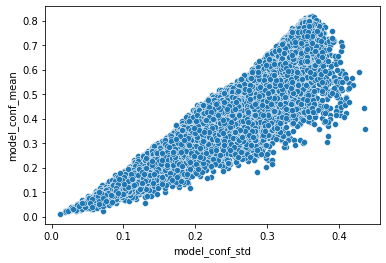

In [77]:
sns.scatterplot(data=data_map_df, x='model_conf_std', y='model_conf_mean')

In [66]:
plot_df['model_conf'].describe()

count    360000.000000
mean          0.256800
std           0.261979
min           0.000000
25%           0.045342
50%           0.170105
75%           0.393251
max           1.000000
Name: model_conf, dtype: float64

In [71]:
all_predictions_df.groupby('dataset')['model_conf'].std()

dataset
dbert       0.257813
dbidaf      0.280776
droberta    0.240713
squad       0.331160
Name: model_conf, dtype: float64